In [1]:
! mkdir -p /root/.pip

In [2]:
%%writefile /root/.pip/pip.conf
[global]
index-url=http://ftp.daumkakao.com/pypi/simple
trusted-host=ftp.daumkakao.com

Overwriting /root/.pip/pip.conf


In [1]:
import time
import datetime
import os
import ast
import sys
import pytz
import random
import shutil
# import splitfolders
import copy
from glob import glob
from tqdm import tqdm
from pprint import pprint

import warnings
import requests

import gc
import math
import numpy as np
import pandas as pd

import cv2
from PIL import Image
# import pydicom as pdm
import pickle
import yaml
import h5py
import json
import matplotlib.pyplot as plt
# import seaborn as sns

import albumentations as albu
import torch
# import torchtuples as tt
from sklearn import metrics

import torchvision
import timm
# import pretrainedmodels

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
    
print('Using PyTorchversion:', torch.__version__, 'Device:', DEVICE)

Using PyTorchversion: 1.10.0+cu113 Device: cuda


In [4]:
DATA_DIR = '/ainode/dataset/train/'
case_lst = [path.split('/')[-1].split('_')[0] for path in glob(DATA_DIR+'flow/*')]
case_lst.sort()

In [5]:
case_dir = case_lst[0]

In [6]:
RGB_DIR = f'./DATA/rgb/{case_dir}_video_01'
FLOWX_DIR = f'./DATA/flowx/{case_dir}_video_01'
FLOWY_DIR = f'./DATA/flowy/{case_dir}_video_01'

rgb_lst = glob(RGB_DIR+'/*.jpg')
flowx_lst = glob(FLOWX_DIR+'/*.jpg')
flowy_lst = glob(FLOWY_DIR+'/*.jpg')

rgb_lst.sort()
flowx_lst.sort()
flowy_lst.sort()

In [7]:
p_annot_df = pd.read_csv(f'./DATA/annot.csv')
p_annot_df['ID'] = list(range(len(p_annot_df)))
p_annot_df.head()

,Event_Number,Event_Label,Start_Time,End_Time,Start_Epoch,End_Epoch,Duration(second),FPS,Frames,Case,ID
0,0,Wake,2020/05/02 22:20:30.000,2020/05/02 22:21:00.000,1,2,30.0,5.0,"[0, 150]",A2020-EM-01-0001,0
1,4,Wake,2020/05/02 22:21:00.000,2020/05/02 22:21:30.000,2,3,30.0,5.0,"[150, 300]",A2020-EM-01-0001,1
2,5,Wake,2020/05/02 22:21:30.000,2020/05/02 22:22:00.000,3,4,30.0,5.0,"[300, 450]",A2020-EM-01-0001,2
3,7,Wake,2020/05/02 22:22:00.000,2020/05/02 22:22:30.000,4,5,30.0,5.0,"[450, 600]",A2020-EM-01-0001,3
4,8,Wake,2020/05/02 22:22:30.000,2020/05/02 22:23:00.000,5,6,30.0,5.0,"[600, 750]",A2020-EM-01-0001,4


In [8]:
caselst = list(dict.fromkeys(p_annot_df['Case'].tolist()).keys())
caselst[10]

'A2020-EM-01-0019'

In [9]:
p_annot_df['Event_Label'].value_counts()

Light Sleep    69757
Wake           31660
Deep Sleep     31366
Name: Event_Label, dtype: int64

In [10]:
fps = p_annot_df['FPS'][0]
print(f"Frame per second: {fps}")

def frame2epoch(frameidx): # image frame number (type 'int') to corresponding start epoch (type 'int')
    return int(frameidx//(30*fps)+1)

def epoch2frame(startepoch): # start epoch (type 'int') to corresponding image frame numbers (type 'list')
    startframe = (startepoch-1)*fps*30
    return np.arange(startframe,startframe+fps*30,1).astype('int').tolist()

Frame per second: 5.0


In [73]:
XX = p_annot_df

In [75]:
XX = XX[['Case', 'Start_Epoch', 'Event_Label']]

In [77]:
XX.rename(columns = {'Case': 'case','Start_Epoch' : 'epoch', 'Event_Label':'answer' }, inplace = True)
XX

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,case,epoch,answer
0,A2020-EM-01-0001,1,Wake
1,A2020-EM-01-0001,2,Wake
2,A2020-EM-01-0001,3,Wake
3,A2020-EM-01-0001,4,Wake
4,A2020-EM-01-0001,5,Wake
...,...,...,...
132778,A2021-EM-01-0170,838,Light Sleep
132779,A2021-EM-01-0170,839,Light Sleep
132780,A2021-EM-01-0170,840,Light Sleep
132781,A2021-EM-01-0170,841,Wake


In [78]:
XX.to_csv('valval_gt_all.csv', index = False)

In [43]:
y = p_annot_df.Event_Label[-1000:]
X = p_annot_df[['ID','Start_Epoch','Case', 'FPS', 'Frames']][-1000:]

# Load Data

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import sklearn

In [13]:
import torchvision.transforms as transforms

In [14]:
with open("total_imgpath.txt", "rb") as fp:   # Unpickling
    total_imgpath = pickle.load(fp)

In [22]:
class Dataset(BaseDataset):
    
    def __init__(
            self,  
            X,
            y,
            total_imgpath,
            augmentation=None, 
            preprocessing=None,
    ):

        self.epochs = X['Start_Epoch'].tolist()
        self.cases = X['Case'].tolist()
        self.fps = X['FPS'].tolist()
        self.ID = X['ID'].tolist()
        self.frames = X['Frames'].tolist()
        self.total_imgpath = total_imgpath
        self.imgpaths = {f'{self.ID[idx]}': f'./max_images/{self.cases[idx]}_{self.epochs[idx]}.npy' for idx in range(len(self.epochs))}
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        le = sklearn.preprocessing.LabelEncoder()
        self.levels = le.fit_transform(y.tolist())
    
    def __getitem__(self, i):
        
        # read data
        idd = list(self.imgpaths.keys())[i]
        idd = int(idd)
        imgs_paths = self.total_imgpath[idd-5:idd+1]
        
        images = []
        for img_path in imgs_paths:
            with open(img_path, 'rb') as f:
                image = np.load(f)
            image = np.transpose(image, (2, 1, 0))
            images.append(image)
            
        images = torch.Tensor(images)
        level = torch.as_tensor(self.levels[i])
        epoch = self.epochs[i]

        return images, level, epoch#, label
        
    def __len__(self):
        return len(self.cases)

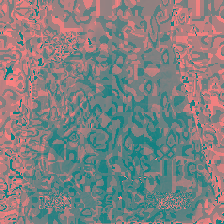

In [23]:
dataset = Dataset(X, y, total_imgpath)
#                   augmentation = get_validation_augmentation()) #, preprocessing = get_preprocessing())
image, level, epoch = dataset[500]

np.array(image).shape
# dataset.cases, dataset.epochs
# np.unique(np.array(images[6]))
# Image.fromarray(np.array(image).astype('uint8'))
# Image.fromarray(np.transpose(np.array(image[0]).astype('uint8')[:,0,:,:], (2,1,0)))
Image.fromarray(np.transpose(np.array(image).astype('uint8')[0,:,:,:], (2,1,0)))

# Load Model

In [44]:
test_dataset = Dataset(X, y,total_imgpath)

test_loader = DataLoader(test_dataset)

In [25]:
class efficientnetb0:
    model_name="efficientnetb0"
    batch_size = 16
    WORKERS = 4
    classes = 9
    epochs = 30
    optimizer = "torch.optim.AdamW"
    optimizer_parm = {'lr':1e-3,'weight_decay':0.00001}
    scheduler = "torch.optim.lr_scheduler.CosineAnnealingLR"
    scheduler_parm = {'T_max':5500,'eta_min':0.000001}
    loss_fn = 'torch.nn.CrossEntropyLoss'
    MODEL_PATH = 'log/cpt'
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

In [26]:
model_config = efficientnetb0

In [27]:
from torchvision.models import efficientnet
from torch import nn

In [28]:
from efficientnet_pytorch import EfficientNet
# cnn = torchvision.models.densenet121(pretrained = True)
cnn = torchvision.models.efficientnet_b0(pretrained=True).cuda()

num_ftrs = cnn.classifier[1].in_features
cnn.classifier[1] = nn.Linear(num_ftrs,3)
cnn.classifier[1] = nn.Sequential(cnn.classifier[1], nn.Softmax(),)

cnn = torch.nn.DataParallel(cnn)
cnn

DataParallel(
  (module): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activ

In [29]:
from torch import nn
from torch.nn import functional as F

class NeuralNet(nn.Module):
    def __init__(self,cnn, embed_size=1280, LSTM_UNITS=64, DO = 0.3):
        super(NeuralNet, self).__init__()
        self.cnn = cnn.module
        self.cnn.eval().cuda()
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)

#         self.linear_pe = nn.Linear(LSTM_UNITS*2, 1)
        self.linear_global = nn.Linear(LSTM_UNITS*2, 3)

    def forward(self, x, lengths=None):
        with torch.no_grad():
            embedding = self.cnn.features(x) #extract_features(x)
            embedding = self.avgpool(embedding)
            b,f,_,_ = embedding.shape
            embedding = embedding.reshape(1,b,f)
        self.lstm1.flatten_parameters()
        h_lstm1, _ = self.lstm1(embedding)
        self.lstm2.flatten_parameters()
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = F.relu(self.linear1(h_lstm1))
        h_conc_linear2  = F.relu(self.linear2(h_lstm2))
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2

        output_global = self.linear_global(hidden.mean(1))
    
        return output_global

In [30]:
model = NeuralNet(cnn).cuda()

In [31]:
optimizer = eval(model_config.optimizer)(model.parameters(),**model_config.optimizer_parm)
scheduler = eval(model_config.scheduler)(optimizer,**model_config.scheduler_parm)
loss_fn = eval(model_config.loss_fn)()#pos_weight=torch.FloatTensor(model_config.pos_weight).cuda())

In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [34]:
import torch
import numpy as np
from tqdm.auto import tqdm
import os
class trainer:
    def __init__(self,loss_fn,model,optimizer,scheduler,config):
        self.loss_fn = loss_fn
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.config = config

        
    def batch_train(self, batch_imgs, batch_labels):
        imgs = batch_imgs.to(DEVICE)
        labels = batch_labels.to(DEVICE)
        self.optimizer.zero_grad()
        predicted = self.model(imgs)
#         predicted = torch.Tensor(predicted)
        loss = criterion(predicted, labels)
        loss.backward()
        self.optimizer.step()
        prediction = predicted.max(1, keepdim=True)[1]
        
#         train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/BATCH_SIZE)
        
        return loss, predicted
    
    def batch_valid(self, batch_imgs,get_fet):
        self.model.eval()
        batch_imgs = batch_imgs.cuda()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
            prediction = predicted.max(1, keepdim=True)[1]
#             predicted[0] = torch.sigmoid(predicted[0])
#             predicted[1] = torch.sigmoid(predicted[1])
#         return prediction
        return prediction, predicted
    
    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
#             print(imgs.shape)
            loss, predicted = self.batch_train(imgs[0], labels)
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(
                    current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step(batch_idx)
#             if batch_idx>10:
#                 break
        return current_loss_mean
    
    def valid_epoch(self, loader,name="valid"):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        correct = 0
        val_loss = AverageMeter()
        val_acc = AverageMeter()
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                imgs = imgs[0].to(DEVICE)
                labels = labels.to(DEVICE)
                predicted = self.model(imgs)
                loss = criterion(predicted, labels)
                prediction = predicted.max(1, keepdim=True)[1]
                
#                 val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/BATCH_SIZE)
                
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
                tqdm_loader.set_description(f"loss : {current_loss_mean:.4}")
#             if batch_idx>10:
#                 break
        score = 1-current_loss_mean
        print('metric {}'.format(score))
        return score
    
    def run(self,train_loder,val_loder):
        best_score = -100000
        for e in range(self.config.epochs):
            print("----------Epoch {}-----------".format(e))
            current_loss_mean = self.train_epoch(train_loder)
            score = self.valid_epoch(val_loder)
            if best_score < score:
                best_score = score
                torch.save(self.model.state_dict(),self.config.MODEL_PATH+"/{}_{}_best.pth".format(datetime.datetime.now(pytz.timezone('Asia/Seoul')).strftime('%Y-%m-%d-%H-%M-%S'),
                                                                                                   self.config.model_name))
                print("==================best model saved===================")

    def batch_valid_tta(self, batch_imgs):
        batch_imgs = batch_imgs.cuda()
        predicted = model(batch_imgs)
        tta_flip = [[-1],[-2]]
        for axis in tta_flip:
            predicted += torch.flip(model(torch.flip(batch_imgs, axis)), axis)
        predicted = predicted/(1+len(tta_flip))
        predicted = torch.sigmoid(predicted)
        return predicted.cpu().numpy()
            
    def load_best_model(self, path):
#         if os.path.exists(self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name)):
        if os.path.exists(path):
            self.model.load_state_dict(torch.load(self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name)))
            print("load best model")
        
    def predict(self,imgs_tensor,get_fet = False):
        self.model.eval()
        with torch.no_grad():
            return self.batch_valid(imgs_tensor,get_fet=get_fet)

In [35]:
Trainer = trainer(loss_fn,model,optimizer,scheduler,config=model_config)

In [41]:
for image, label, epoch in test_loader:
    if epoch > 5:
        print(image[0].shape)
        break

torch.Size([6, 3, 224, 224])


In [38]:
Trainer.load_best_model('2021-11-02-21-37-08_efficientnetb0_best.pth  efficientnetb0_best.pth')

In [45]:
predicted_labels = []
predicted_values = []
true_labels = []

dd = 0
for image, label, epoch in tqdm(test_loader):
    true_labels.append(label)
    if epoch > 5:
#         print(Trainer.predict(image[0])[1][0])
        predicted_values.append(Trainer.predict(image[0])[1][0])
        predicted_labels.append(int(Trainer.predict(image[0])[0][0][0]))
    else:
        dd+=1
        predicted_values.append(torch.Tensor([0,0,1]))
        predicted_labels.append(2)

  0%|          | 0/1000 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: './max_images/A2021-EM-01-0170_842.npy'

In [46]:
predicted_labels
# predicted_values
# true_labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [59]:
with open('valval_predicted_labels_lstm_v001.npy', 'wb') as f:
    np.save(f, np.array(predicted_labels))

with open('valval_predicted_values_lstm_v001.npy', 'wb') as f:
    np.save(f, np.array(predicted_values))
    
with open('valval_groundtruth_v001.npy', 'wb') as f:
    np.save(f, np.array(list(y[:-1])))

In [53]:
list(y) == true_labels

False

In [54]:
len(list(y))

1000

In [55]:
len(true_labels)

999

In [58]:
y[:-1]

131783     Deep Sleep
131784     Deep Sleep
131785    Light Sleep
131786    Light Sleep
131787    Light Sleep
             ...     
132777    Light Sleep
132778    Light Sleep
132779    Light Sleep
132780    Light Sleep
132781           Wake
Name: Event_Label, Length: 999, dtype: object

In [62]:
X = X[:-1]

In [63]:
X

,ID,Start_Epoch,Case,FPS,Frames
131783,131783,580,A2021-EM-01-0169,4.995,"[86763, 86913]"
131784,131784,581,A2021-EM-01-0169,4.995,"[86913, 87062]"
131785,131785,582,A2021-EM-01-0169,4.995,"[87062, 87212]"
131786,131786,583,A2021-EM-01-0169,4.995,"[87212, 87362]"
131787,131787,584,A2021-EM-01-0169,4.995,"[87362, 87512]"
...,...,...,...,...,...
132777,132777,837,A2021-EM-01-0170,4.995,"[125274, 125424]"
132778,132778,838,A2021-EM-01-0170,4.995,"[125424, 125574]"
132779,132779,839,A2021-EM-01-0170,4.995,"[125574, 125724]"
132780,132780,840,A2021-EM-01-0170,4.995,"[125724, 125874]"


In [65]:
y = y[:-1]

In [67]:
X = X[['Case', 'Start_Epoch']]

In [69]:
X['answer'] = list(y)

<ipython-input-69-340163d9db8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['answer'] = list(y)


In [71]:
X.to_csv('valval_gt.csv', index = False)

In [20]:
import pickle

with open("test_total_imgpath.txt", "wb") as fp:   #Pickling
    pickle.dump(total_imgpath, fp)

# with open("test_total_imgpath.txt", "rb") as fp:   # Unpickling
#     total_imgpath = pickle.load(fp)

In [21]:
X

,Case,Epoch,Epoch_Count,Frame_Count,Frame_Rate,Frame,ID
0,A2020-EM-01-0005,0,923,138163,4.995,"[0, 149]",0
1,A2020-EM-01-0005,1,923,138163,4.995,"[149, 299]",1
2,A2020-EM-01-0005,2,923,138163,4.995,"[299, 449]",2
3,A2020-EM-01-0005,3,923,138163,4.995,"[449, 599]",3
4,A2020-EM-01-0005,4,923,138163,4.995,"[599, 749]",4
...,...,...,...,...,...,...,...
32883,A2021-EM-01-0163,929,935,139323,4.972,"[138569, 138718]",32883
32884,A2021-EM-01-0163,930,935,139323,4.972,"[138718, 138867]",32884
32885,A2021-EM-01-0163,931,935,139323,4.972,"[138867, 139017]",32885
32886,A2021-EM-01-0163,932,935,139323,4.972,"[139017, 139166]",32886


In [22]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import sklearn

In [116]:
class Dataset(BaseDataset):
    
    def __init__(
            self,  
            X,
            total_imgpath,
            augmentation=None, 
            preprocessing=None,
    ):

        self.epochs = X['Epoch'].tolist()
        self.cases = X['Case'].tolist()
        self.fps = X['Frame_Count'].tolist()
        self.frames = X['Frame'].tolist()
        self.ID = X['ID'].tolist()
        self.total_imgpath = total_imgpath
        self.imgpaths = {f"{self.ID[idx]}": f'./test_max_images/{self.cases[idx]}_{int(self.epochs[idx])+1}.npy' for idx in range(len(self.epochs))}
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        
        idd = list(self.imgpaths.keys())[i]
        idd = int(idd)
        imgs_paths = self.total_imgpath[idd-5:idd+1]
        
        images = []
        for img_path in imgs_paths:
            with open(img_path, 'rb') as f:
                image = np.load(f)
            image = np.transpose(image, (2, 1, 0))
            images.append(image)
        
        images = torch.Tensor(images)
        epoch = self.epochs[i]
        
        return images, epoch
        
    def __len__(self):
        return len(self.cases)

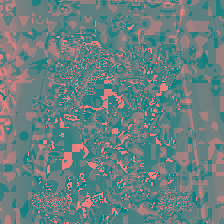

In [133]:
dataset = Dataset(X, total_imgpath)
#                   augmentation = get_validation_augmentation()) #, preprocessing = get_preprocessing())
image, epoch = dataset[500]

np.array(image).shape
# dataset.cases, dataset.epochs
# np.unique(np.array(images[6]))
# Image.fromarray(np.array(image).astype('uint8'))
# Image.fromarray(np.transpose(np.array(image[0]).astype('uint8')[:,0,:,:], (2,1,0)))
Image.fromarray(np.transpose(np.array(image).astype('uint8')[0,:,:,:], (2,1,0)))

# Load Model

In [134]:
class efficientnetb0:
    model_name="efficientnetb0"
    batch_size = 16
    WORKERS = 4
    classes = 9
    epochs = 30
    optimizer = "torch.optim.AdamW"
    optimizer_parm = {'lr':1e-3,'weight_decay':0.00001}
    scheduler = "torch.optim.lr_scheduler.CosineAnnealingLR"
    scheduler_parm = {'T_max':5500,'eta_min':0.000001}
    loss_fn = 'torch.nn.CrossEntropyLoss'
    MODEL_PATH = 'log/cpt'
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

In [135]:
model_config = efficientnetb0

In [136]:
from torchvision.models import efficientnet
from torch import nn

In [137]:
from efficientnet_pytorch import EfficientNet
# cnn = torchvision.models.densenet121(pretrained = True)
cnn = torchvision.models.efficientnet_b0(pretrained=True).cuda()

num_ftrs = cnn.classifier[1].in_features
cnn.classifier[1] = nn.Linear(num_ftrs,3)
cnn.classifier[1] = nn.Sequential(cnn.classifier[1], nn.Softmax(),)

cnn = torch.nn.DataParallel(cnn)
cnn

DataParallel(
  (module): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activ

In [138]:
from torch import nn
from torch.nn import functional as F

class NeuralNet(nn.Module):
    def __init__(self,cnn, embed_size=1280, LSTM_UNITS=64, DO = 0.3):
        super(NeuralNet, self).__init__()
        self.cnn = cnn.module
        self.cnn.eval().cuda()
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)

#         self.linear_pe = nn.Linear(LSTM_UNITS*2, 1)
        self.linear_global = nn.Linear(LSTM_UNITS*2, 3)

    def forward(self, x, lengths=None):
        with torch.no_grad():
            embedding = self.cnn.features(x) #extract_features(x)
            embedding = self.avgpool(embedding)
            b,f,_,_ = embedding.shape
            embedding = embedding.reshape(1,b,f)
        self.lstm1.flatten_parameters()
        h_lstm1, _ = self.lstm1(embedding)
        self.lstm2.flatten_parameters()
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = F.relu(self.linear1(h_lstm1))
        h_conc_linear2  = F.relu(self.linear2(h_lstm2))
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2

        output_global = self.linear_global(hidden.mean(1))
    
        return output_global

In [139]:
model = NeuralNet(cnn).cuda()

In [140]:
optimizer = eval(model_config.optimizer)(model.parameters(),**model_config.optimizer_parm)
scheduler = eval(model_config.scheduler)(optimizer,**model_config.scheduler_parm)
loss_fn = eval(model_config.loss_fn)()#pos_weight=torch.FloatTensor(model_config.pos_weight).cuda())

In [141]:
criterion = nn.CrossEntropyLoss()

In [142]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [167]:
import torch
import numpy as np
from tqdm.auto import tqdm
import os
class trainer:
    def __init__(self,loss_fn,model,optimizer,scheduler,config):
        self.loss_fn = loss_fn
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.config = config

        
    def batch_train(self, batch_imgs, batch_labels):
        imgs = batch_imgs.to(DEVICE)
        labels = batch_labels.to(DEVICE)
        self.optimizer.zero_grad()
        predicted = self.model(imgs)
#         predicted = torch.Tensor(predicted)
        loss = criterion(predicted, labels)
        loss.backward()
        self.optimizer.step()
        prediction = predicted.max(1, keepdim=True)[1]
        
#         train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/BATCH_SIZE)
        
        return loss, predicted
    
    def batch_valid(self, batch_imgs,get_fet):
        self.model.eval()
        batch_imgs = batch_imgs.cuda()
        with torch.no_grad():
            predicted = self.model(batch_imgs)
            prediction = predicted.max(1, keepdim=True)[1]
#             predicted[0] = torch.sigmoid(predicted[0])
#             predicted[1] = torch.sigmoid(predicted[1])
#         return prediction
        return prediction, predicted
    
    def train_epoch(self, loader):
        self.model.train()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
#             print(imgs.shape)
            loss, predicted = self.batch_train(imgs[0], labels)
            current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
            tqdm_loader.set_description('loss: {:.4} lr:{:.6}'.format(
                    current_loss_mean, self.optimizer.param_groups[0]['lr']))
            self.scheduler.step(batch_idx)
#             if batch_idx>10:
#                 break
        return current_loss_mean
    
    def valid_epoch(self, loader,name="valid"):
        self.model.eval()
        tqdm_loader = tqdm(loader)
        current_loss_mean = 0
        correct = 0
        val_loss = AverageMeter()
        val_acc = AverageMeter()
        for batch_idx, (imgs,labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                imgs = imgs[0].to(DEVICE)
                labels = labels.to(DEVICE)
                predicted = self.model(imgs)
                loss = criterion(predicted, labels)
                prediction = predicted.max(1, keepdim=True)[1]
                
#                 val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/BATCH_SIZE)
                
                current_loss_mean = (current_loss_mean * batch_idx + loss) / (batch_idx + 1)
                tqdm_loader.set_description(f"loss : {current_loss_mean:.4}")
#             if batch_idx>10:
#                 break
        score = 1-current_loss_mean
        print('metric {}'.format(score))
        return score
    
    def run(self,train_loder,val_loder):
        best_score = -100000
        for e in range(self.config.epochs):
            print("----------Epoch {}-----------".format(e))
            current_loss_mean = self.train_epoch(train_loder)
            score = self.valid_epoch(val_loder)
            if best_score < score:
                best_score = score
                torch.save(self.model.state_dict(),self.config.MODEL_PATH+"/{}_{}_best.pth".format(datetime.datetime.now(pytz.timezone('Asia/Seoul')).strftime('%Y-%m-%d-%H-%M-%S'),
                                                                                                   self.config.model_name))
                print("==================best model saved===================")

    def batch_valid_tta(self, batch_imgs):
        batch_imgs = batch_imgs.cuda()
        predicted = model(batch_imgs)
        tta_flip = [[-1],[-2]]
        for axis in tta_flip:
            predicted += torch.flip(model(torch.flip(batch_imgs, axis)), axis)
        predicted = predicted/(1+len(tta_flip))
        predicted = torch.sigmoid(predicted)
        return predicted.cpu().numpy()
            
    def load_best_model(self, path):
#         if os.path.exists(self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name)):
        if os.path.exists(path):
            self.model.load_state_dict(torch.load(self.config.MODEL_PATH+"/{}_best.pth".format(self.config.model_name)))
            print("load best model")
        
    def predict(self,imgs_tensor,get_fet = False):
        self.model.eval()
        with torch.no_grad():
            return self.batch_valid(imgs_tensor,get_fet=get_fet)

In [168]:
Trainer = trainer(loss_fn,model,optimizer,scheduler,config=model_config)

In [169]:
test_dataset = Dataset(X, total_imgpath)

test_loader = DataLoader(test_dataset)

In [170]:
for image, epoch in test_loader:
    if epoch > 4:
        print(image[0].shape)
        break

torch.Size([6, 3, 224, 224])


In [171]:
!ls ./log/cpt/

2021-11-02-21-37-08_efficientnetb0_best.pth  efficientnetb0_best.pth


In [172]:
Trainer.load_best_model('2021-11-02-21-37-08_efficientnetb0_best.pth  efficientnetb0_best.pth')

In [186]:
predicted_labels.count(0),\
predicted_labels.count(1),\
predicted_labels.count(2)

(89, 227, 262)

In [ ]:
predicted_labels = []
predicted_values = []
dd = 0
for image, epoch in tqdm(test_loader):
    if epoch > 4:
#         print(Trainer.predict(image[0])[1][0])
        predicted_values.append(Trainer.predict(image[0])[1][0])
        predicted_labels.append(int(Trainer.predict(image[0])[0][0][0]))
    else:
        dd+=1
        predicted_values.append(torch.Tensor([0,0,1]))
        predicted_labels.append(2)

  0%|          | 0/32888 [00:00<?, ?it/s]

In [ ]:
with open('predicted_labels_lstm_v001.npy', 'wb') as f:
    np.save(f, np.array(predicted_labels))

with open('predicted_values_lstm_v001.npy', 'wb') as f:
    np.save(f, np.array(predicted_values))

In [ ]:
X.to_csv('test_csv.csv', index = False)

In [ ]:
len(predicted_values)